In [1]:
datapath = '/home/wbm001/data/Result/version8/internaltest.csv'
modelpath = '/home/wbm001/data/Result/version8/premodels/model699.pkl'

seq_modelpath = '/home/wbm001/data/dti_data/Model/seq_model/saved_models/prose_mt_3x1024.sav'
mol_modelpath = '/home/wbm001/data/dti_data/Model/mol_model/model_300dim.pkl'

In [2]:
import pandas as pd

data = pd.read_csv(datapath, low_memory=False)

In [3]:
data = data.iloc[:,1:]
data = data.dropna()
data

,Ki (log10),mol0,mol1,mol2,mol3,mol4,mol5,mol6,mol7,mol8,...,seq6155,seq6156,seq6157,seq6158,seq6159,seq6160,seq6161,seq6162,seq6163,seq6164
0,0.397940,-0.107738,-2.591364,-2.569378,5.457989,0.675885,-0.480670,-8.928061,-1.842389,6.830656,...,-14.963593,-49.762173,-0.314640,11.912315,-3.796101,-39.340126,2.122688,30.589684,87.600365,73.295590
1,-3.897627,5.208026,-4.472837,-5.252691,9.961682,0.576880,-0.581290,-20.541454,-0.158533,14.208355,...,-6.555532,-85.019420,5.454101,10.669722,19.052723,-3.326373,42.431217,-2.803369,123.845740,29.467392
2,-1.716003,4.089204,-3.036177,-1.725518,4.628867,-1.136407,-0.240234,-7.015096,-0.100006,4.915881,...,-24.022028,-83.741620,-2.189890,18.321247,-5.269813,-65.497220,7.623410,-44.320650,97.664795,74.917690
3,-0.301030,0.790533,-1.213229,-2.822123,4.070034,-0.278554,-0.430919,-8.843210,0.621854,7.296265,...,-2.925493,-42.237810,24.339160,-5.135384,-2.865352,-72.854250,8.824728,-61.064167,56.443287,-7.895694
4,-4.853089,1.257051,-3.780795,-2.577870,7.388154,2.179640,1.128746,-13.795278,-0.455640,9.572718,...,-9.977728,-61.388474,31.153456,21.486431,14.049877,-37.313885,31.346323,59.338974,269.722000,2.817990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49899,-1.875061,1.806379,0.804888,-2.267057,2.788965,1.890501,-1.084289,-9.891449,0.665362,7.283176,...,-1.910517,-62.353508,-0.591695,10.658049,-1.931800,-76.721275,5.999241,-12.711279,94.449370,66.840454
49900,-2.806180,1.690441,-6.618949,-2.530524,3.346742,-3.077290,-2.027446,-8.640225,1.209024,3.064542,...,-54.353676,-153.446180,-4.481597,23.508470,-27.203352,-64.837700,34.359100,-59.413414,132.458800,7.931567
49901,0.282329,5.239948,-5.868832,-4.580723,5.455685,-0.627147,-2.665251,-13.311697,-1.446056,6.631473,...,-1.998598,-31.489473,16.527916,8.716137,18.714640,21.395565,11.439966,-8.709448,29.518936,0.286072
49902,-2.612784,-2.952886,-8.175998,-4.424906,-0.088276,-0.317951,-13.304016,-18.629236,5.154816,4.982527,...,-2.025296,-35.575283,20.231369,-2.428431,-1.695565,-78.148834,7.497446,-52.702820,33.010340,-7.910441


In [4]:
import numpy as np
import torch
from torch.utils.data import DataLoader,TensorDataset,SequentialSampler,RandomSampler
from torch import tensor

seq = tensor(np.array(data.iloc[:,301:6467])).unsqueeze(dim=1).to(torch.float32)
mol = tensor(np.array(data.iloc[:,1:301])).unsqueeze(dim=1).to(torch.float32)
Ki = tensor(np.array(data.iloc[:,0]))

dataset = TensorDataset(mol,seq,Ki)
dataloader = DataLoader(dataset, batch_size=128)

In [5]:
from torch.nn import Module
from torch import nn
import torch.nn.functional as F
import torch

# block ------------------------------------------------------------------------
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, use_conv1=False, strides=1):
        super().__init__()
        
        self.process = nn.Sequential (
            nn.Conv1d(in_channels, out_channels, 3, stride=strides, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Conv1d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm1d(out_channels)
        )
        
        if use_conv1:
            self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=strides)
        else:
            self.conv1 = None
        
    def forward(self, x):
        left = self.process(x)
        right = x if self.conv1 is None else self.conv1(x)
        
        return F.relu(left + right)

# cnnNet ------------------------------------------------------------------------
class cnnNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pre = nn.Sequential (
            nn.Conv1d(1, 32, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.MaxPool1d(2)
        )
        
        self.layer1 = self._make_layer(32, 16, 2)
        
        
    def _make_layer(self, in_channels, out_channels, block_num, strides=1):

        layers = [Block(in_channels, out_channels, use_conv1=True, strides=strides)] # build the first layer with conv1
        
        for i in range(block_num):
            layers.append(Block(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.pre(x)
        x = self.layer1(x)
        
        return x

torch.cuda.empty_cache()

# mainNet ------------------------------------------------------------------------
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.mol_cnn = cnnNet()
        self.seq_cnn = cnnNet()
        
        self.pooling = nn.AvgPool1d(5, stride = 3)
        
        self.lstm = nn.LSTM(538, 64, num_layers=2, batch_first=True, bidirectional=True)
        
        self.linear = nn.Sequential (
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            
            nn.Linear(512, 32),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(p=0.2),
            
#             nn.Linear(128, 32),
#             nn.BatchNorm1d(32),
            #nn.ReLU(),
#             nn.Dropout(p=0.5),
            
            nn.Linear(32, 1),
        )

    def forward(self, mol, seq):
        mol = self.mol_cnn(mol)
        seq = self.seq_cnn(seq)
        
        # put data into lstm        
        x = torch.cat((mol,seq),2)
        x = self.pooling(x)
        x,_ = self.lstm(x)
        
        # fully connect layer
        x = x.flatten(1)
        x = self.linear(x)
        
        return x.flatten()

# initialize weight
def initialize_weights(m):
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)

    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [6]:
model = torch.load(modelpath)

model = model.eval()

In [7]:
from pytorch_lightning.metrics.functional import r2score
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

loss_fn = nn.MSELoss()

re = np.array([])
true = np.array([])

for batch in tqdm(dataloader):
        input_mols, input_seqs, labels = tuple(t.to("cuda") for t in batch)
        
        with torch.no_grad():
            logits = model(input_mols, input_seqs)
        
        re = np.append(re,np.array(logits.to("cpu")))
        true = np.append(true,np.array(labels.to("cpu")))

re

  0%|          | 0/390 [00:00<?, ?it/s]

/home/wbm001/miniconda3/envs/molseq/lib/python3.9/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


array([ 0.25229672, -2.83272958, -2.20370221, ..., -0.25756609,
       -2.15390825, -1.02224231])

(array([2.000e+01, 2.400e+01, 2.300e+01, 1.700e+01, 2.800e+01, 1.500e+01,
        2.700e+01, 2.700e+01, 3.800e+01, 1.900e+01, 2.600e+01, 3.000e+01,
        2.300e+01, 4.400e+01, 6.000e+01, 8.600e+01, 7.600e+01, 9.100e+01,
        9.900e+01, 1.100e+02, 1.170e+02, 1.370e+02, 1.620e+02, 2.020e+02,
        2.460e+02, 2.940e+02, 3.780e+02, 4.400e+02, 4.110e+02, 4.920e+02,
        9.560e+02, 8.700e+02, 9.770e+02, 1.017e+03, 1.073e+03, 1.091e+03,
        1.096e+03, 1.502e+03, 1.473e+03, 1.594e+03, 1.543e+03, 1.669e+03,
        1.566e+03, 1.564e+03, 1.513e+03, 1.560e+03, 1.689e+03, 1.792e+03,
        1.629e+03, 1.942e+03, 1.473e+03, 1.306e+03, 1.812e+03, 1.534e+03,
        1.443e+03, 1.428e+03, 1.160e+03, 9.820e+02, 1.038e+03, 8.290e+02,
        9.230e+02, 7.720e+02, 7.980e+02, 4.770e+02, 4.490e+02, 4.000e+02,
        2.670e+02, 1.540e+02, 2.540e+02, 1.460e+02, 8.200e+01, 9.700e+01,
        2.200e+01, 4.300e+01, 3.100e+01, 3.900e+01, 7.000e+00, 2.100e+01,
        6.000e+00, 9.000e+00, 4.000e+0

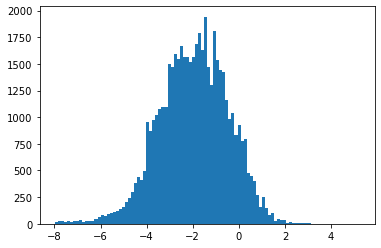

In [8]:
arrki = []
arrmol0 = []

for i in range(len(re)):
    if re[i] - 5.23063898 < 0.01:
        arrki.append(true[i])
        arrmol0.append(data.iloc[i]["mol0"])
        
plt.hist(arrki,bins=100)


In [9]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
from math import sqrt

print("MSE: \t\t" + str(mse(true,re)))
print("MAE: \t\t" + str(mae(true,re)))
print("r2: \t\t" + str(r2(true,re)))
print("RMSE: \t\t" + str(sqrt(mse(true,re))))
print("r: \t\t" + str(sqrt(r2(true,re))))

MSE: 		0.6448249634392959
MAE: 		0.5966166583633995
r2: 		0.7109178562395696
RMSE: 		0.8030099398135093
r: 		0.843159448882339


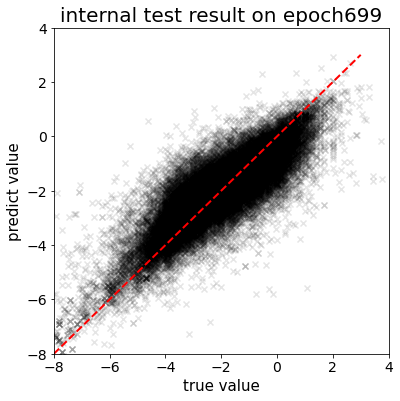

In [10]:
from matplotlib import pyplot as plt


plt.figure(figsize=(6,6))
plt.xlabel("true value",fontsize=15)
plt.ylabel("predict value",fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-8,4)
plt.ylim(-8,4)
plt.scatter(true,re,alpha=0.1,marker="x",color="Black")
plt.plot(range(-8,4),range(-8,4),color="r",linestyle="--",linewidth=2)
plt.title("internal test result on epoch699",fontsize=20)
plt.savefig("model699 - innertest.svg")